# Jupyter Notebook 2.2: Datenverarbeitung.kNN.scikitlearn - Lösung

Zu Beginn des Notebooks werden die Bilbiotheken eingebunden, welche innerhalb des Notebooks zur Verarbeitung genutzt werden.

In [1]:
import matplotlib.pyplot as plt # Bibliothek für Visualisierungen
import numpy as np # Bibliothek für wissenschaftliche Berechnungen
import pandas as pd # Bibliothek zur Datenanalyse
import sklearn # Bibliothek zum maschinellen Lernen

In [2]:
import warnings
warnings.filterwarnings(action='ignore', message='X does not have valid feature names, but KNeighborsClassifier was fitted with feature names')

<hr style="border:1px solid black"> </hr>

### Problemstellung und Vorbereitung: Risse in Stahlproben

In der letzten Sitzung wurde das Stahlprojekt eingeleitet. Der folgend untersuchte (und von Ihnen bereits einmal bearbeitete) Datensatz gehört zu diesem Projekt: 

Die Entwicklungsabteilung der Firma hat eine Untersuchung in Auftrag gegeben, in der die Oberfläche von aktuell verbauten Stahlbauteilen (also aus dem ursprünglichen Material) untersucht wurde. Hierbei wurden drei unterschiedliche Eigenschaften erhoben: 

- Ein Risserkennungsprogramm identifizierte in den Bauteilen Mikrorisse. Im Fokus standen dabei die Anzahl und die Breite des größten Risses. 
- Ingenieur:innen beurteilten rein optisch jedes Bauteil bezüglich ihrer Qualität. Es wurde dabei zwischen "muss nicht innerhalb des nächsten Jahres ausgewechselt werden" (gut) und "muss innerhalb des nächsten Jahres ausgewechselt werden" (schlecht) unterschieden. 

Der Datensatz enthält 497 untersuchte Bauteile, für jedes Bauteil sind die Anzahl der Risse, die Breite des größten Risses und die Kategorisierung in "gut" und "schlecht" angegeben.

![Risse](Stahl.jpg)

Die folgenden Zellen wurden im Rahmen des letzten Jupyter Notebooks bereits genutzt, um die Daten einzulesen und für die Visualisierung vorzubereiten, und werden nun auch hier ausgeführt.

In [3]:
daten = pd.read_excel(r'Qualitaet.xlsx')
daten

,Ausschuss,Anzahl Risse,Größter Riss
0,schlecht,1057,707.41
1,gut,918,494.58
2,gut,1079,571.30
3,schlecht,971,707.41
4,schlecht,1143,770.59
...,...,...,...
492,schlecht,1175,784.13
493,gut,961,598.38
494,schlecht,886,720.95
495,gut,757,643.51


<div class="alert alert-block alert-success">
<b>Arbeitsauftrag:</b> Führen Sie die folgenden Zellen aus, um den Datensatz auf die Verabreitung vorzubereiten. Erinnern Sie sich, wozu die einzelnen Befehle eingesetzt wurden und kommentieren Sie die Codezeilen in den Zellen. 
</div>

In [4]:
daten = daten.dropna()
daten = daten.replace("gut",0)
daten = daten.replace("schlecht",1)
daten = daten.replace("schlehct",1)
display(daten)

,Ausschuss,Anzahl Risse,Größter Riss
0,1,1057,707.41
1,0,918,494.58
2,0,1079,571.30
3,1,971,707.41
4,1,1143,770.59
...,...,...,...
492,1,1175,784.13
493,0,961,598.38
494,1,886,720.95
495,0,757,643.51


<hr style="border:1px solid black"> </hr>

### Visualisierung

Für die Visualisierung des Datensatzes hat sich ein Streudiagramm bereits als wertvoll erwiesen. Hierfür werden zunächst neue Variablen definiert und im Anschluss das Streudiagramm visualisiert.

In [5]:
X = daten.iloc[:,1:3]
klasse = daten['Ausschuss']

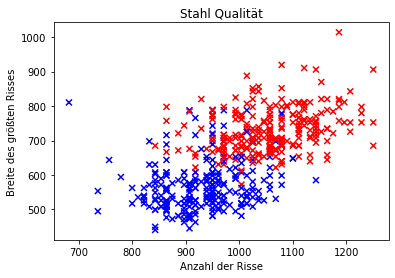

In [6]:
plt.scatter(X['Anzahl Risse'],X['Größter Riss'],c=klasse.values,marker='x',cmap="bwr")
plt.title('Stahl Qualität') 
plt.xlabel('Anzahl der Risse') 
plt.ylabel('Breite des größten Risses') 
plt.show; 

Der folgende Code definiert eine komplexere Möglichkeit der Visualisierung, die im weiteren Verlauf des Notebooks noch hilfreich sein wird. Die einzelnen Zeilen müssen nicht nachvollzogen werden und die Funktionalität wird in einem späteren Arbeitsauftrag erläutert. 

In [7]:
from matplotlib.colors import ListedColormap

cmap_bold = ListedColormap(['#0000FF', '#00FF00', '#FF0000'])
cmap_light = ListedColormap(['#AAAAFF', '#AAFFAA', '#FFAAAA'])
font_size=25

def meshGrid(x_data, y_data):
    h = 2  # step size in mesh, ursprünglich 0.02
    x_min, x_max = x_data.min() - 1, x_data.max() + 1
    y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)
    
def plotPrediction(clf, x_data, y_data, x_label, y_label, colors, title="", mesh=True):
    xx,yy = meshGrid(x_data, y_data)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(20,10))
    if mesh:
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.scatter(x_data, y_data, c=colors, cmap=cmap_bold, s=80, marker='o')
    plt.xlabel(x_label, fontsize=font_size)
    plt.ylabel(y_label, fontsize=font_size)
    plt.title(title, fontsize=font_size)

<hr style="border:1px solid black"> </hr>

### kNN Klassifikation

Die Python Bibliothek sklearn ist die Standard-Bibliothek zur Nutzung von maschinellen Lernverfahren. Sie ist Ihnen bereits im Online-Kurs begnet. In der folgenden Zelle wird ein Modul zur kNN Klassifikation aus der sklearn Bibliothek importiert. Außerdem wird die Funktion <tt>train_test_split</tt> importiert, mit der die Unterteilung des Datensatzes in Trainings- und Testmenge vorgenommen wird. 

In [8]:
# Import der kNN Klassifikation aus der scikitklearn Bibliothek
from sklearn import neighbors 
from sklearn.model_selection import train_test_split

Der erste Schritt ist die Unterteilung des Datensatzes in Trainingsmenge und Testmenge mit der Funktion <tt>train_test_split</tt>. Anschließend soll mit Hilfe der kNN Klassifikation ein Modell zu den Trainingsdaten gefittet werden. Die dritte Zeile der nachfolgenden Zelle definiert, dass die Variable <tt>clf</tt> ein Modell nach der Idee der kNN Klassifikation mit <tt>k=1</tt> Nachbarn enthält. Die dritte Zeile fittet das Modell bezüglich der Daten <tt>X_train</tt> und <tt>y_train</tt>, legt also die Zuordnung für künftige Klassifikation fest. 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, klasse, test_size=0.3, random_state=42, stratify=klasse)
k = 1
clf = neighbors.KNeighborsClassifier(k) 
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

Um zu visualisieren, was nach dem Fitten in <tt>clf</tt> gespeichert ist, wird in der nachfolgenden Zelle auf die oben angelegte Funktion <tt>plotPrediction</tt> zugegriffen. Die Funktion plottet das Modell, gespeichert in der Variable <tt>clf</tt>, sowie die zugrundeliegenden Trainingsdaten.

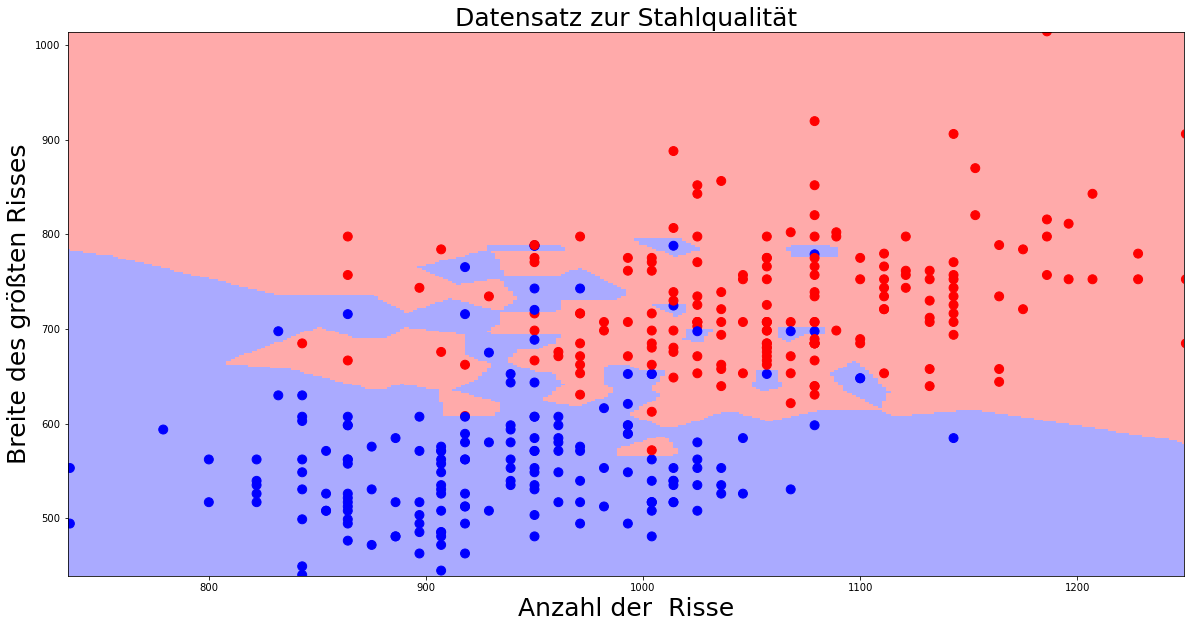

In [10]:
plotPrediction(clf, X_train.iloc[:,0:1].values, X_train.iloc[:,1:2].values, 'Anzahl der  Risse', 'Breite des größten Risses', y_train, title="Datensatz zur Stahlqualität")

Um die Variable <tt>clf</tt> weiter zu erkunden, wird zunächst der Datentyp betrachtet:

In [11]:
type(clf)

sklearn.neighbors._classification.KNeighborsClassifier

Der Datentyp <tt>sklearn.neighbors._classification.KNeighborsClassifier</tt> bringt wiederum neue Methoden mit sich. Zum Beispiel wird mit dem Befehl <tt>clf.predict([['Featureausprägung 1','Featureausprägung 2']])</tt> das Label für die angegebenen Featureausprägungen vorhergesagt.

<div class="alert alert-block alert-success">
<b>Arbeitsauftrag:</b> Ergänzen Sie den Befehl in der nachfolgenden Zelle mit zwei in den Kontext passenden Featurausprägungen. Welches Label wird vorhergesagt? </div> 

In [12]:
# Platz für Arbeitsauftrag
clf.predict([[900,800]]) #clf.predict([['Featureausprägung 1','Featureausprägung 2']])

array([1], dtype=int64)

<div class="alert alert-block alert-success">
<b>Frage:</b> Passt das Label, das Sie haben vorhersagen lassen, zu der obigen Grafik? <br>
</div>

**Antwort:** 

Es wird nun mit Hilfe der Visualisierung ein Modell mit einer anderen Metrik (Betragsmetrik) und mit mehr Nachbarn dargestellt.

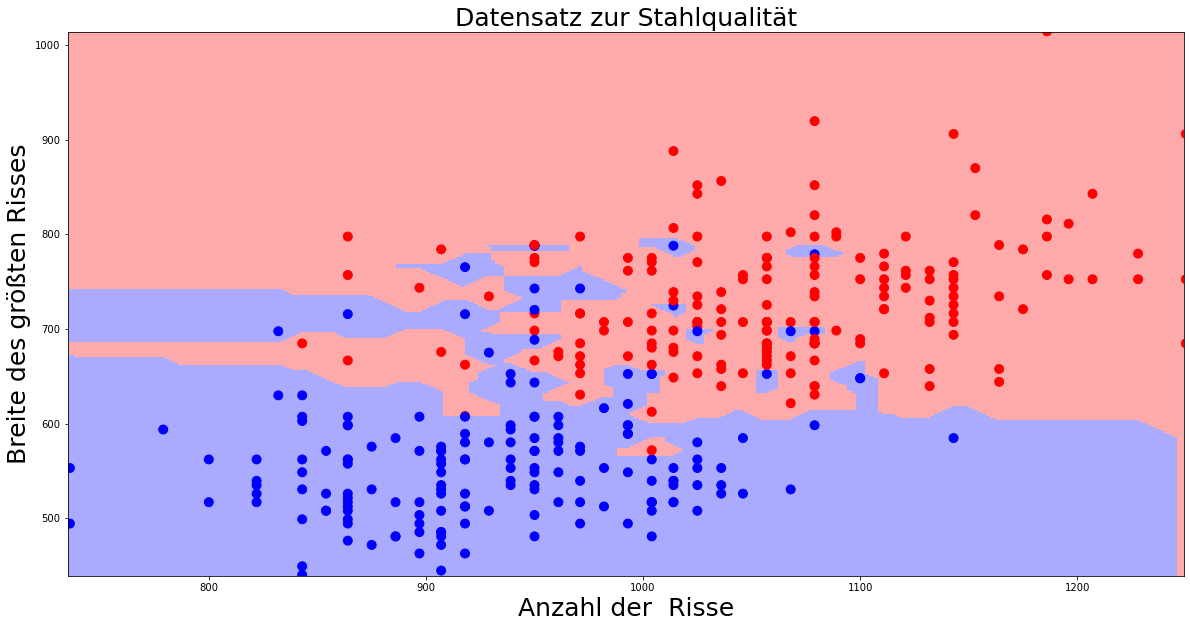

In [13]:
k = 1
clf_2 = neighbors.KNeighborsClassifier(k,p=1)
clf_2.fit(X_train, y_train)
plotPrediction(clf_2, X_train['Anzahl Risse'], X_train['Größter Riss'], 'Anzahl der  Risse', 'Breite des größten Risses', y_train, title="Datensatz zur Stahlqualität")

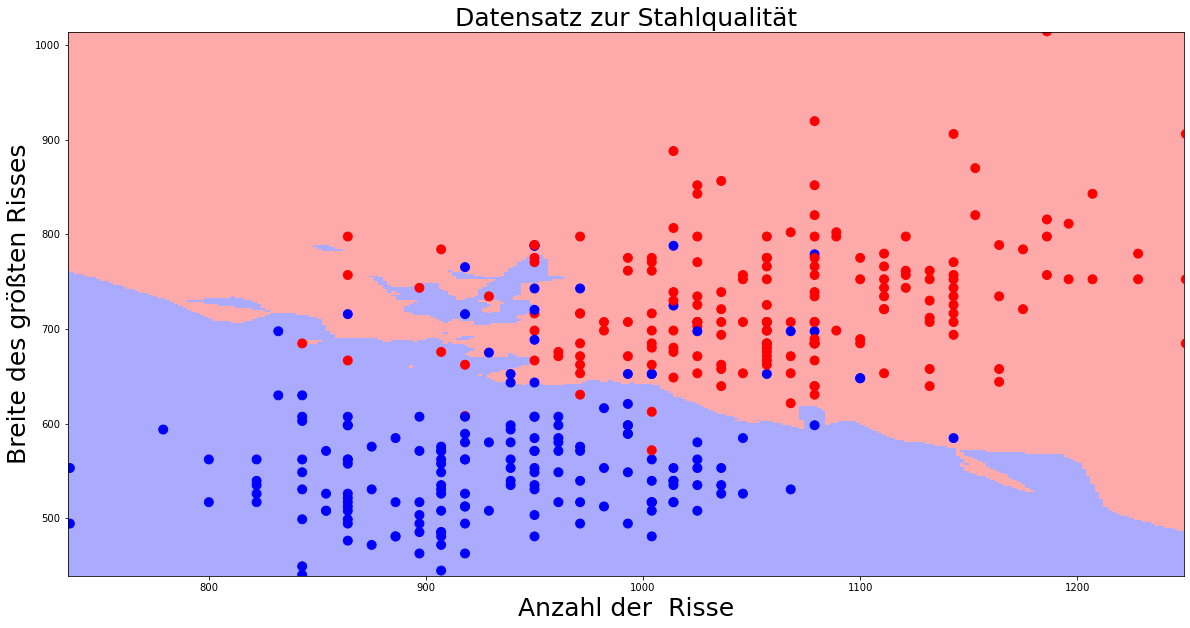

In [14]:
k = 10
clf_3 = neighbors.KNeighborsClassifier(k) 
clf_3.fit(X_train, y_train)
plotPrediction(clf_3, X_train['Anzahl Risse'], X_train['Größter Riss'], 'Anzahl der  Risse', 'Breite des größten Risses', y_train, title="Datensatz zur Stahlqualität")

<div class="alert alert-block alert-success">
<b>Frage 1:</b> Worin unterscheiden sich die Modelle? <br> 
<b>Frage 2:</b> Woran sieht man (im oberen Code), dass die Betragsmetrik verwendtet wird? </div>

**Antwort 1:** Im Modell mit der Betragsmetrik wirken die Bereiche in die Breite gezogen. Dies liegt an der unterschiedlichen Skalierung der Merkmale auf x- und y-Achse, die bei dieser Metrik stärker zum Tragen kommt. Im Modell mit mehr Nachbarn gibt es weniger kleine Flächen, sondern eher eine große Gesamtfläche.

**Antwort 2:** $p=1$ in Zeile 2 ist die Kennziffer der Betragsmetrik im Gegensatz zu $p=2$ für die euklidische. 

Ein Mittel zur Auswahl eines Modells ist der Vergleich der Klassifikation des Modells mit den bereits bekannten Labeln des Testdatensatzes. Auch hierfür kann die obige Visualisierung genutzt werden, indem das Modell zusammen mit den Testdaten dargestellt wird. 

<div class="alert alert-block alert-success">
<b>Arbeitsauftrag:</b> Ergänze die Variablen in der folgenden Zelle, sodass die Visualisierung des Modells mit einem Nachbarn und euklidischer Metrik, sowie der Testmenge geplottet wird. </div>

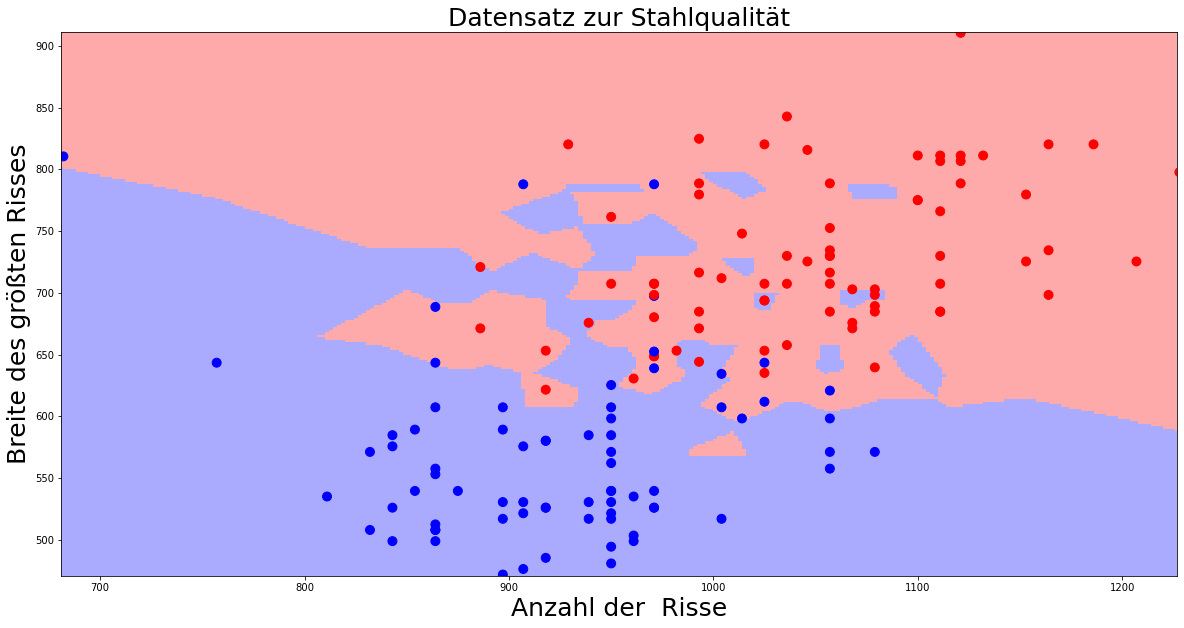

In [15]:
# Platz für Arbeitsauftrag
plotPrediction(clf, X_test['Anzahl Risse'], X_test['Größter Riss'], 'Anzahl der  Risse', 'Breite des größten Risses', y_test, title="Datensatz zur Stahlqualität")